## Import and wrangle data into a usable format

Code below to import the dataset and the libraries we need. 

In [64]:
import msoffcrypto
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create an in-memory buffer
temp = io.BytesIO()

# Open the encrypted Excel file
with open('data/NIDC_South East_202324.xlsx', 'rb') as f:
    excel = msoffcrypto.OfficeFile(f)
    excel.load_key(password='Snidc24dow6')
    excel.decrypt(temp)

# Read the decrypted file into a pandas DataFrame
df = pd.read_excel(temp, sheet_name='3. Asset Register')

# Drop columns: '2023/2024 Part 1', 'CollectionName' and 6 other columns
df = df.drop(columns=['2023/2024 Part 1', 
                      'CollectionName', 
                      'RegionCode', 
                      'RegionName', 
                      'ReportingPeriodStart', 
                      'ReportingPeriodEnd', 
                      'SubmittedDatetime', 
                      'SubmissionStatus'])

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Display the DataFrame
df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Mon_Fri,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,0.0,12.0,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty


Count of machine type by asset status

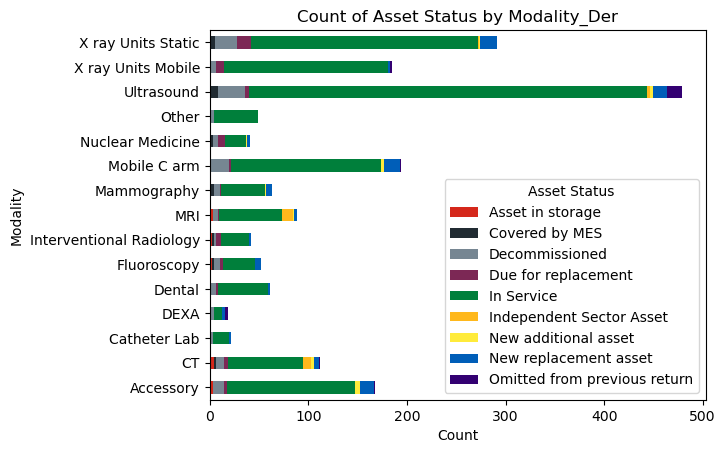

In [29]:
# Count the occurrences
count_data = df.groupby(['Modality_Der', 'Asset Status']).size().unstack().fillna(0)

# NHS colour palette dictionary
nhs_colours = {
    'Asset in storage': '#d5281b', # warm yellow
    'Covered by MES': '#212b32', # black
    'Decommissioned': '#768692', # grey 1
    'Due for replacement': '#7C2855', # red
    'In Service': '#007f3b', # blue
    'Independent Sector Asset': '#ffb81C', # yellow
    'New additional asset': '#ffeb3b', # green
    'New replacement asset': '#005eb8', # yellow
    'Omitted from previous return': '#330072' # purple
}

# Plotting
count_data.plot(kind='barh', stacked=True, color=[nhs_colours[col] for col in count_data.columns])
plt.title('Count of Asset Status by Modality_Der')
plt.xlabel('Count')
plt.ylabel('Modality')
plt.legend(title='Asset Status')
plt.show()

Scatterplot count of modality vs avg age of asset, by provider

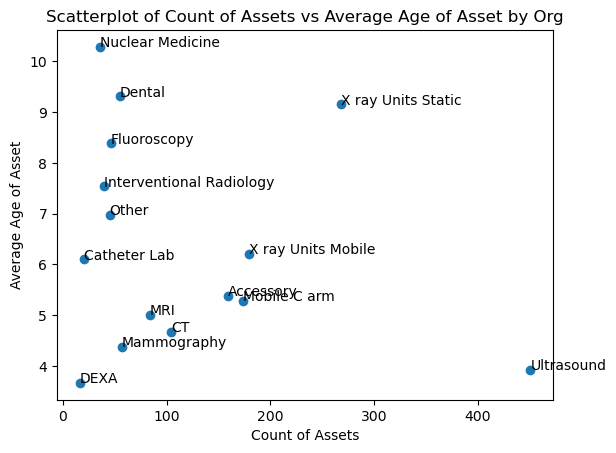

In [45]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Group by OrganisationName to get the count and average age_of_asset
grouped_df = df.groupby('Modality_Der').agg(
    count_modality=('Modality_Der', 'count'),
    avg_age_of_asset=('Age', 'mean')
).reset_index()


# Create a scatter plot
plt.scatter(grouped_df['count_modality'], grouped_df['avg_age_of_asset'])

# Add labels and title
plt.xlabel('Count of Assets')
plt.ylabel('Average Age of Asset')
plt.title('Scatterplot of Count of Assets vs Average Age of Asset by Org')

# Label dots with OrganisationName
for i, row in grouped_df.iterrows():
    plt.text(row['count_modality'], row['avg_age_of_asset'], row['Modality_Der'])

# Show the plot
plt.show()

Asset type by age

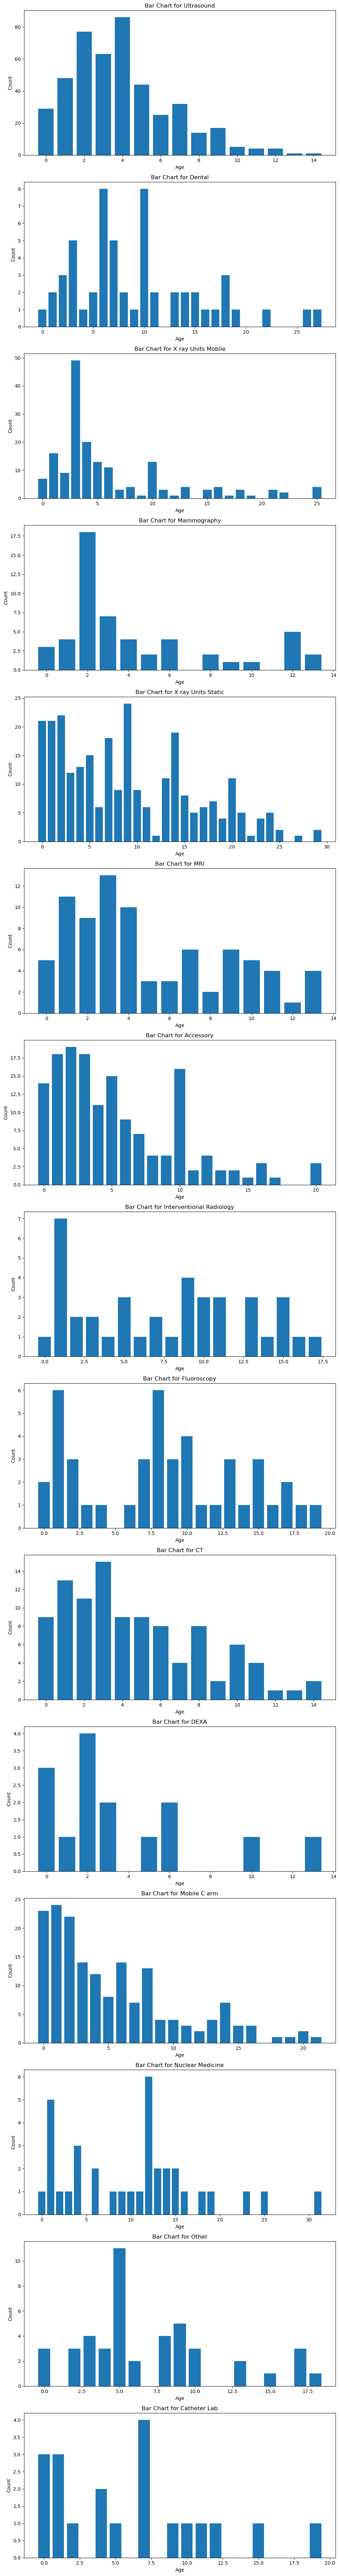

In [66]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Get unique Modality_Der values
modalities = df['Modality_Der'].unique()

# Create subplots for each Modality_Der
fig, axes = plt.subplots(nrows=len(modalities), ncols=1, figsize=(10, 5 * len(modalities)))

# If there's only one subplot, convert axes to a list
if len(modalities) == 1:
    axes = [axes]

# Group by OrganisationName to get the count and average age_of_asset
for i, modality in enumerate(modalities):
    modality_df = df[df['Modality_Der'] == modality]
    grouped_df = modality_df.groupby('Age').agg(
        count_modality=('Modality_Der', 'count')
    ).reset_index()

    # Creating the bar plot
    axes[i].bar(grouped_df['Age'], grouped_df['count_modality'])
    axes[i].set_title(f'Bar Chart for {modality}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Count')

    # # Label bars with age
    # for j, row in grouped_df.iterrows():
    #     axes[i].text(j, row['count_modality'], row['Age'], ha='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Replacement schedule and cost dictionaries

In [76]:
replacement_schedule = {
'Accessory': 5,
'CT': 8,
'Catheter Lab': 8,
'DEXA': 10,
'Dental': 10,
'Fluoroscopy': 8,
'Interventional Radiology': 8,
'MRI': 8,
'Mammography': 5,
'Mobile C arm': 8,
'Nuclear Medicine': 8,
'Other': 0,
'Ultrasound': 5,
'X ray Units Mobile': 8,
'X ray Units Static': 8,
}

replacement_cost = {
'Accessory': 22500,
'CT': 935000,
'Catheter Lab': 900000,
'DEXA': 88000,
'Dental': 33000,
'Fluoroscopy': 660000,
'Interventional Radiology': 935000,
'MRI': 1210000,
'Mammography': 330000,
'Mobile C arm': 90000,
'Nuclear Medicine': 880000,
'Other': 0,
'Ultrasound': 90000,
'X ray Units Mobile': 85000,
'X ray Units Static': 120000,
}

Stacked bar chart by provider

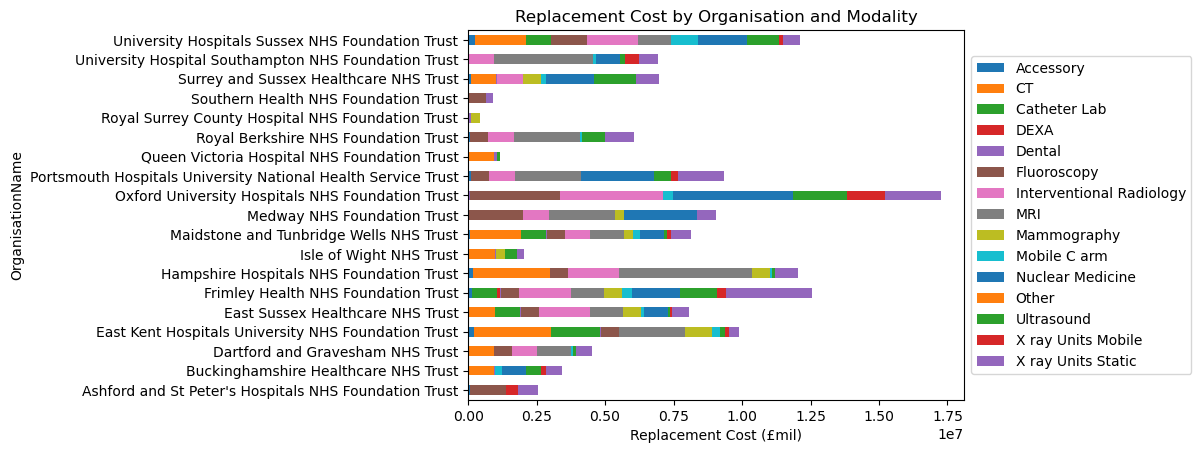

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,replacement_cost,replacement_schedule
18,RN7,Dartford and Gravesham NHS Trust,A028,120450,RN707,Imaging Department,Image Acquisition,Interventional Radiology,Single Plane,Philips Healthcare,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,450000,In Service,Manufacturer provides maintenance,935000,8
33,RHW,Royal Berkshire NHS Foundation Trust,A060,Aplioi 700 WBCH Rm 2,O412S,Community Diagnostic Centre NHS Asset,Image Acquisition,Ultrasound,Ultrasound - General,Canon,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56400,In Service,Manufacturer provides maintenance,90000,5
36,RHW,Royal Berkshire NHS Foundation Trust,A079,Philips cx50 IR uss,RHW01,Angiography Suite,Image Acquisition,Ultrasound,2D with CEUS / Elastography / Fusion Capabilit...,Philips Healthcare,...,0.0,24.0,0.0,Capital purchase - new,Capital purchase - new,51734,New replacement asset,No Maintenance in Place,90000,5
37,RTP,Surrey and Sussex Healthcare NHS Trust,A014,ES-EPU US,RTP04,Maternity Department,Image Acquisition,Ultrasound,2D – Obstetric,GE Medical Systems,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,50000,In Service,Manufacturer provides maintenance,90000,5
40,RYR,University Hospitals Sussex NHS Foundation Trust,A006,RAD0019,RXH09,Imaging Department,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,180000,In Service,Third Party Supplier provides maintenance,120000,8


In [84]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Add replacement_cost to the DataFrame
df['replacement_cost'] = df.apply(lambda row: replacement_cost[(row['Modality_Der'])], axis=1)
df['replacement_schedule'] = df.apply(lambda row: replacement_schedule[(row['Modality_Der'])], axis=1)

# Only where Age > replacement_schedule
df = df[df['Age'] > df['replacement_schedule']]

# Pivot the DataFrame to get the data in the format required for a stacked bar chart
pivot_df = df.pivot_table(index='OrganisationName', columns='Modality_Der', values='replacement_cost', aggfunc='sum').fillna(0)

# Create a stacked bar chart
pivot_df.plot(kind='barh', stacked=True)

# Add labels and title
plt.xlabel('Replacement Cost (£mil)')
plt.ylabel('OrganisationName')
plt.title('Replacement Cost by Organisation and Modality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()